In [40]:
import pandas as pd                               # panda
import pandas_datareader as pdr                   # Baixar dados yahoo

import matplotlib.pyplot as plt                   # grafico
import matplotlib.dates as mdates                 # trabalhar datas

import statsmodels.api as sm                      # regressao
from statsmodels.api import add_constant          # para a regressao considerar o intercepto

import numpy as np
import scipy.stats

from statsmodels.tsa.stattools import coint       # Funcao Coint ()
from statsmodels.tsa.stattools import adfuller

# Declaracoes
pd.options.display.float_format = '{:.2f}'.format


### DECLARACAO DE FUNCOES ###

In [3]:
def baixar_yahoo(tickers,inicio,fim,baixayahoo):

    db = pd.DataFrame()
    # Percorre a lista tickers, lendo o yahoo e salvando no DataFrame db
    if (baixayahoo == True):
        
        for i in tickers:
            cot = pdr.DataReader(i, 'yahoo', inicio,fim)
            cot['Ativo']=i
            db = pd.concat([db,cot],sort=True)  

        db.to_csv('Ativos.csv')
        #db.to_excel('Ativos.xlsx')
    
    db = pd.read_csv('Ativos.csv',parse_dates=[0], infer_datetime_format = True)
    db = db[['Ativo','Date','Open','High','Low','Adj Close']].rename(columns={'Adj Close': 'Close'})    
    
    return db

In [19]:
## FUNCOES DE TESTES DE COINTEGRACAO E DE ESTACIONARIEDADE

#!pip install arch
from arch.unitroot import PhillipsPerron
from arch.unitroot import ADF


# ADF da Statsmodel -
def adftest(df,ativo):

    adf  = adfuller(df, maxlag=1, autolag='BIC')
    if adf[0]   < adf[4]['1%']:  adfc='99%'
    elif adf[0] < adf[4]['5%']:  adfc='95%'
    elif adf[0] < adf[4]['10%']: adfc='90%'
    else:                        adfc='0%'                 

    return adf[0], adfc;      


In [87]:
## Funcoes graficas

def grafico_residuo(df):
        
    plt.figure(figsize=(20,4))
    ax = df.plot(color='g', grid=True, label='Z-Score')
    plt.axhline(df.mean(), color='red')
    plt.axhline(df.mean()+2*df.std(), color='blue')
    plt.axhline(df.mean()-2*df.std(), color='blue')

    ax.xaxis_date()  # formata o timestamp para o formato data
    ax.set_axisbelow(True)
    ax.set_title('Residuos', color='black')
    ax.set_facecolor('white')
    ax.figure.set_facecolor('white')

    plt.legend()
    plt.show()    
        

In [80]:

tickers = ['ENAT3.SA', 'BRAP4.SA'];

# Busca cotacoes no Yahoo Finance
df = baixar_yahoo(tickers, '2019-1-1','2020-7-22',True)

# Cria Tabela com os fechamentos dos dois ativos [DATA, Close1, Close2]
esquerda = df[df['Ativo']==tickers[0]].set_index('Date')['Close']
direita = df[df['Ativo']==tickers[1]].set_index('Date')['Close']
par = pd.merge(left=esquerda, right=direita, left_on='Date', right_on='Date').rename(columns={'Close_x': tickers[0], 'Close_y': tickers[1]})

par.to_excel('Par.xlsx')

# Cria o cubo de periodos
cubo = pd.DataFrame(columns=['Periodo','Dickey_Fuller','ADF','Coef_Ang','QTD_Desvios','Fisher_min','Fisher_max'])


# Popula o cubo de periodos
#for i in range(100,260,10):
for i in [100,120,140,160,180,200,220,240,250]:
    
    # Adiciona o PERIODO analisado no dataframe
    cubo = cubo.append({'Periodo': int(i)}, ignore_index=True)
    
    # Cria subset do par[] para o periodo(i) atual da iteração 
    par_subset = par.tail(i)
    
    # Gera a REGRESSAO LINEAR MULTIVARIADA (QuantGo "Simples") -> y = b*x + c*t + d + e
    X = np.column_stack((par_subset[tickers[1]], range(1,i+1,1)))
    X = sm.add_constant(X, prepend=True)
    res = sm.OLS(par_subset[tickers[0]],X).fit()
    cubo.loc[cubo['Periodo']==i, 'Coef_Ang']=res.params[1]   
    
    # Cria as colunas 'residuo' e 'zscore' no par_subset1 (queria colocar no par_subset, mas ta dando warning)
    par_subset1 = pd.DataFrame()
    par_subset1['residuo'] = par_subset[tickers[0]]-res.predict()
    par_subset1['zscore']  = (par_subset1['residuo'] - np.mean(par_subset1['residuo']))/np.std(par_subset1['residuo']);
    cubo.loc[cubo['Periodo']==i, 'QTD_Desvios']=par_subset1['zscore'].tail(1).values
    
    # Teste de Estacionariedade dos Resíduos (ADF)
    adfstat,adfc = adftest(par_subset1['residuo'], "Residuo")
    cubo.loc[cubo['Periodo']==i, 'Dickey_Fuller']=adfstat
    cubo.loc[cubo['Periodo']==i, 'ADF']=adfc 

    # Calculo da Meia-vida
    
    
    
display(cubo)


print("Desvio Medio do Coef. Angular: {:.2%}" .format(cubo['Coef_Ang'].std()/cubo['Coef_Ang'].mean()))



,Periodo,Dickey_Fuller,ADF,Coef_Ang,QTD_Desvios,Fisher_min,Fisher_max
0,100.00,-4.76,99%,0.37,-1.77,nan,nan
1,120.00,-5.27,99%,0.48,-1.90,nan,nan
2,140.00,-5.74,99%,0.48,-2.01,nan,nan
3,160.00,-4.73,99%,0.48,-2.10,nan,nan
4,180.00,-4.98,99%,0.48,-2.37,nan,nan
5,200.00,-4.59,99%,0.51,-2.63,nan,nan
6,220.00,-4.47,99%,0.52,-2.87,nan,nan
7,240.00,-4.70,99%,0.52,-3.02,nan,nan
8,250.00,-4.79,99%,0.52,-3.09,nan,nan


Desvio Medio do Coef. Angular: 9.41%


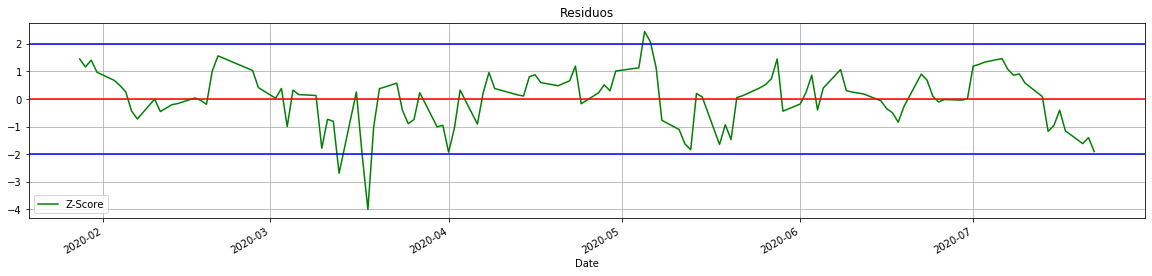

In [88]:
# Gera os graficos do Desvio para o periodo selecionado

##### Substituir pelo periodo que quer analisar  ######
periodo = 120;
##### Substituir pelo periodo que quer analisar  ######
        
X = np.column_stack((par[tickers[1]].tail(int(periodo)), range(1,int(periodo)+1,1)))
X = sm.add_constant(X, prepend=True)
res = sm.OLS(par[tickers[0]].tail(int(periodo)),X).fit()

par_subset1 = pd.DataFrame()
par_subset1['residuo'] = par[tickers[0]].tail(periodo)-res.predict()
par_subset1['zscore']  = (par_subset1['residuo'] - np.mean(par_subset1['residuo']))/np.std(par_subset1['residuo']);

grafico_residuo(par_subset1['zscore'])

